## Assigment 4

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from itertools import combinations
from random import sample, seed
from a4_utils import *
seed(100)

### helper functions

In [2]:
def readGrayF64(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE).astype(np.float64) / 255

In [4]:
def gaussdx(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) * (-x/(np.sqrt(2*np.pi) * sigma**3))
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(abs(r))).reshape(1, r.shape[0])

def gaussian(sigma):
    f = lambda x: np.exp(-x**2/(2*sigma**2)) / (np.sqrt(2*np.pi) * sigma)
    r = np.array(list(map(f, np.arange(-3*sigma, 3*sigma+1))))
    return (r / sum(r)).reshape(1, r.shape[0])

def g_gdx(o=2):
    if o is None:
        o = 2
    return gaussian(o), -gaussdx(o)

def imgDX(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g.T), -1, kernel=gdx)

def imgDY(I, o=2):
    g, gdx = g_gdx(o)
    return cv2.filter2D(cv2.filter2D(I, -1, kernel=g), -1, kernel=gdx.T)

def imgDXX(I, o=2):
    return imgDX(imgDX(I, o), o)

def imgDXY(I, o=2):
    return imgDY(imgDX(I, o), o)

def imgDYX(I, o=2):
    return imgDX(imgDY(I, o), o)

def imgDYY(I, o=2):
    return imgDY(imgDY(I, o), o)

In [5]:
def nonmaxsuppression(I, nb=1):
    if nb == 0:
        return I

    Is = I.copy()
    box_step = 2*nb
    for y in range(0, Is.shape[0], box_step):
        for x in range(0, Is.shape[1], box_step):
            y_lim = min(y + box_step, Is.shape[0] -1)
            x_lim = min(x + box_step, Is.shape[1] -1)
            neighboruhood = Is[y:y_lim, x:x_lim]
            maxiumum = np.max(neighboruhood)
            maximums = np.argwhere(neighboruhood == maxiumum)
            maximum_index = maximums[len(maximums)//2]
            Is[y:y_lim, x:x_lim] = 0
            Is[y+maximum_index[0], x+maximum_index[1]] = maxiumum
            
    return Is


In [6]:
def hellinger_distance(hist_A, hist_B):
    return np.sum((np.sqrt(hist_A) - np.sqrt(hist_B))**2) ** 0.5 / np.sqrt(2)

### Exercise 1

#### A

In [7]:
def hessian_points(I, o=None, t=None, nb=0):
    Ixx = imgDXX(I, o)
    Iyy = imgDYY(I, o)
    Ixy = imgDXY(I, o)

    detI = np.multiply(Ixx, Iyy) - np.multiply(Ixy, Ixy)

    if t is not None:
        detI[detI < t] = 0
        detI = nonmaxsuppression(detI, nb)
        
    return detI

Text(0.5, 1.0, 'higher sigma')

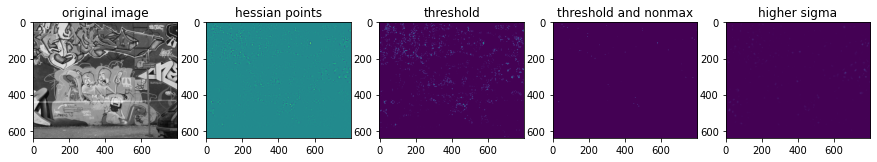

In [8]:
test_points = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
test_points_features = hessian_points(test_points)
test_points_keypoints = hessian_points(test_points, t=0.001)
test_points_keypoints_nonmax = hessian_points(test_points, t=0.01, nb=1)
test_points_keypoints_nonmax2 = hessian_points(test_points, o=6, t=0.001, nb=2)

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

axes[0].imshow(test_points, cmap="gray")
axes[0].set_title("original image")

axes[1].imshow(test_points_features)
axes[1].set_title("hessian points")

axes[2].imshow(test_points_keypoints)
axes[2].set_title("threshold")

axes[3].imshow(test_points_keypoints_nonmax)
axes[3].set_title("threshold and nonmax")

axes[4].imshow(test_points_keypoints_nonmax2)
axes[4].set_title("higher sigma")

In [9]:
def plot_with_keypoints(I, points, axes=None):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(5, 5))
    axes.imshow(I, cmap="gray")
    axes.scatter(points[:, 1], points[:, 0], s=3, c="r")
    axes.set_xlabel("num points: {}".format(len(points)))


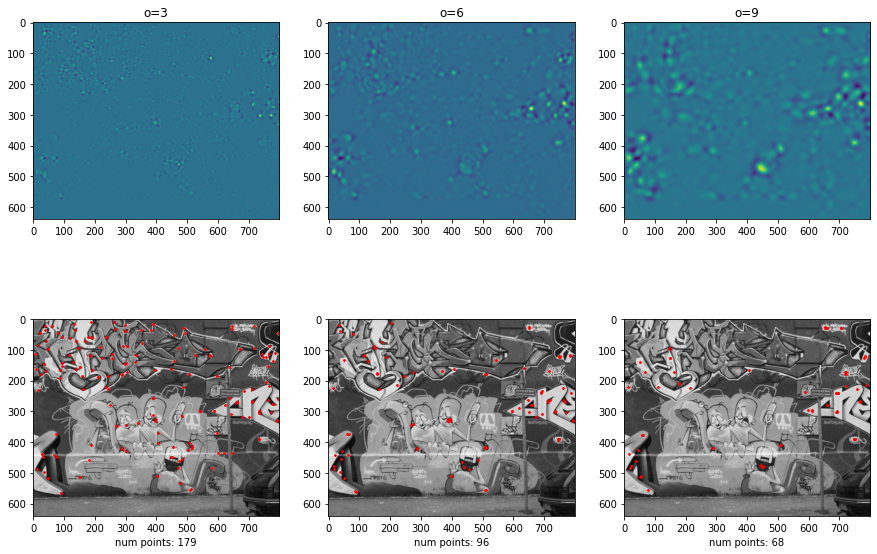

In [10]:
o_options = [3, 6, 9]
t = 0.004
nb = 15

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = hessian_points(test_points, o=o_options[i])

    axes[0, i].imshow(points, cmap="viridis")
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points, cmap="afmhot")
    keypoints = hessian_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])
        

question 1

#### B

In [11]:
def harris_points(I, o=2, o_after=None, alpha=0.06, t=None, nb=0):
    if o_after is None:
        o_after = 1.6 * o
    afterGK = np.flip(gauss(o_after))
    Ix = imgDX(I, o)
    Iy = imgDY(I, o)
    
    C11 = cv2.filter2D(Ix**2, ddepth=-1, kernel=afterGK)
    C12 = cv2.filter2D(Ix*Iy, ddepth=-1, kernel=afterGK)
    C21 = cv2.filter2D(Iy*Ix, ddepth=-1, kernel=afterGK)
    C22 = cv2.filter2D(Iy**2, ddepth=-1, kernel=afterGK)

    detC = C11*C22 - C12*C21
    traceC = C11 + C22

    value = detC - alpha * (traceC**2)

    if t is not None:
        value[value < t] = 0
        value = nonmaxsuppression(value, nb)
    return value

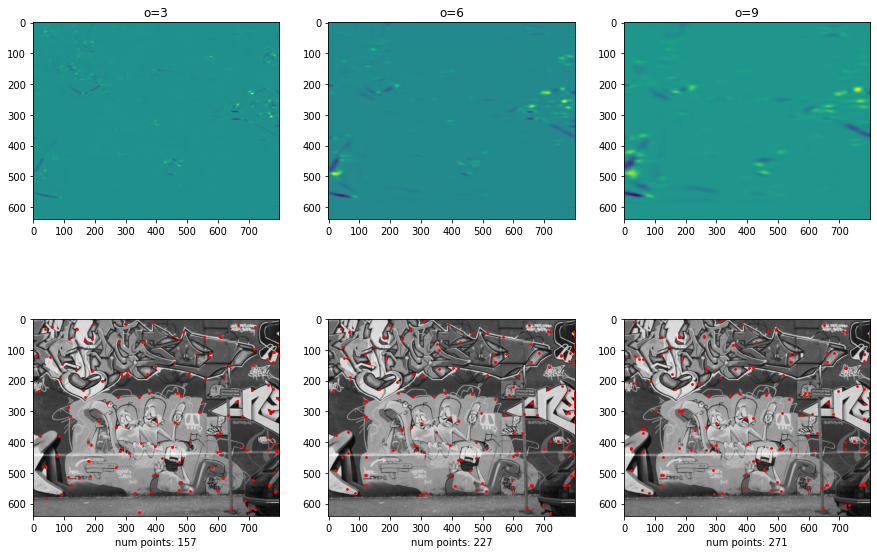

In [12]:
o_options = [3, 6, 9]
t = 10**-6
nb = 30

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(len(o_options)):
    points = harris_points(test_points, o=o_options[i])

    axes[0, i].imshow(points)
    axes[0, i].set_title("o={}".format(o_options[i]))

    axes[1, i].imshow(points)
    keypoints = harris_points(test_points, o=o_options[i], t=t, nb=nb)
    plot_with_keypoints(test_points, np.argwhere(keypoints > 0), axes[1, i])

in task question

### Exercise 2

#### A

In [13]:
def find_correspondences(descriptorsA, descriptorsB, reverse=False):
    matches = []
    distances = []
    for dAi in range(len(descriptorsA)):
        # default basepoint for comparison
        if not reverse:
            matches.append((dAi, 0))
        else:
            matches.append((0, dAi))
        distances.append(hellinger_distance(descriptorsA[dAi], descriptorsB[0]))

        # find best match for point from A
        for dBi in range(1, len(descriptorsB)):
            distance = hellinger_distance(descriptorsA[dAi], descriptorsB[dBi])
            if distance < distances[-1]:
                if not reverse:
                    matches[-1] = (dAi, dBi)
                else:
                    matches[-1] = (dBi, dAi)
                distances[-1] = distance
    return matches

In [14]:
graf_a_small = readGrayF64("./assigments/assigment4/data/graf/graf_a_small.jpg")
graf_b_small = readGrayF64("./assigments/assigment4/data/graf/graf_b_small.jpg")
graf_a_small.shape, graf_b_small.shape

((289, 340), (289, 340))

In [15]:
graf_a_small_keypoints = np.argwhere(harris_points(graf_a_small, o=6, t=10**-6, nb=10) > 0)
graf_b_small_keypoints = np.argwhere(harris_points(graf_b_small, o=6, t=10**-6, nb=10) > 0)
len(graf_a_small_keypoints), len(graf_b_small_keypoints)

(224, 207)

In [16]:
graf_a_small_descriptors = simple_descriptors(graf_a_small, graf_a_small_keypoints[:, 0], graf_a_small_keypoints[:, 1])
graf_b_small_descriptors = simple_descriptors(graf_b_small, graf_b_small_keypoints[:, 0], graf_b_small_keypoints[:, 1])
len(graf_a_small_descriptors), len(graf_b_small_descriptors)

(224, 207)

In [17]:
graf_a_b_small_correspondences = find_correspondences(graf_a_small_descriptors, graf_b_small_descriptors)
correspondences_indexes = list(zip(*graf_a_b_small_correspondences))

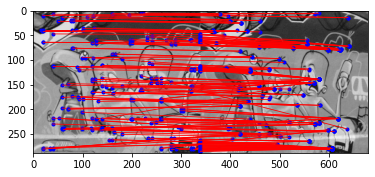

In [18]:
graf_small_a_points_ordered = np.take(graf_a_small_keypoints, correspondences_indexes[0], axis=0)
graf_small_b_points_ordered = np.take(graf_b_small_keypoints, correspondences_indexes[1], axis=0)

display_matches(graf_a_small, graf_small_a_points_ordered, graf_b_small, graf_small_b_points_ordered)

#### B

In [19]:
def simple_descriptors_wrapper(I, Y, X):
    points = np.array((Y, X)).T
    return simple_descriptors(I, Y, X), points

def find_matches(IA, IB, o=6, t=10**-6, nb=10, descriptors=simple_descriptors_wrapper):
    keypoints_A = np.argwhere(harris_points(IA, o=o, t=t, nb=nb) > 0)
    keypoints_B = np.argwhere(harris_points(IB, o=o, t=t, nb=nb) > 0)

    descriptorsA, keypoints_A = descriptors(IA, keypoints_A[:, 0], keypoints_A[:, 1])
    descriptorsB, keypoints_B = descriptors(IB, keypoints_B[:, 0], keypoints_B[:, 1])

    correspondences_A_B = find_correspondences(descriptorsA, descriptorsB)
    correspondences_B_A = find_correspondences(descriptorsB, descriptorsA, reverse=True)

    symetric_correspondences = set(correspondences_A_B).intersection(set(correspondences_B_A))

    correspondences_info = list(zip(*symetric_correspondences))

    points_A_ordered = np.take(keypoints_A, correspondences_info[0], axis=0)
    points_B_ordered = np.take(keypoints_B, correspondences_info[1], axis=0)

    return points_A_ordered, points_B_ordered

In [20]:
pointsA, pointsB = find_matches(graf_a_small, graf_b_small, o=2, t=10**-6, nb=15)
len(pointsA), len(pointsB)

(46, 46)

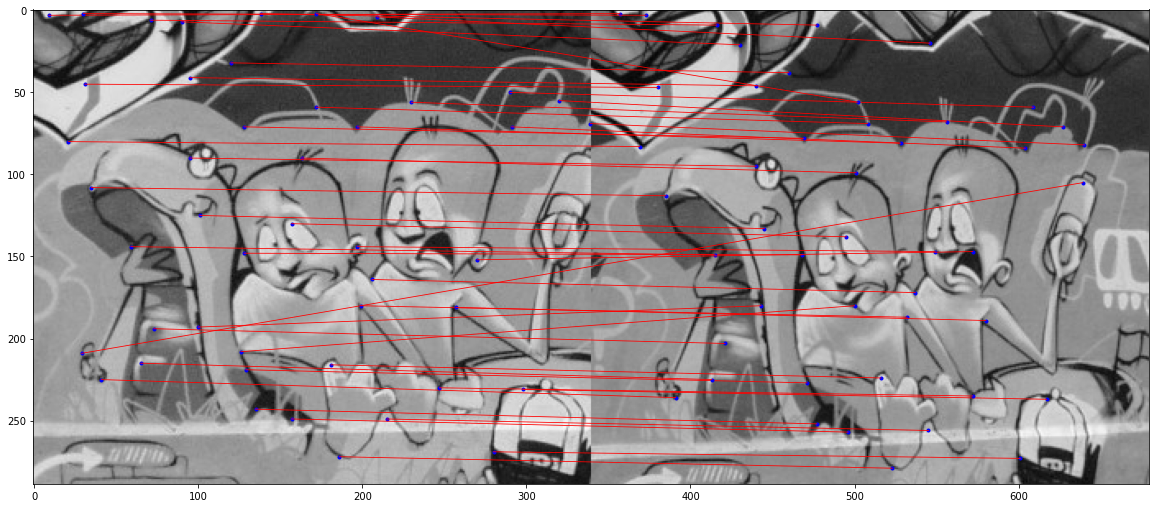

In [21]:
fig = plt.figure(figsize=(20, 10))
display_matches(graf_a_small, pointsA, graf_b_small, pointsB)

question

### Exercise 3

#### A

question

question

In [22]:
def estimate_homography(pointsA, pointsB):
    # construct matrix A of homogenous system Ah = 0
    A = np.zeros((2*len(pointsA), 9))
    for i in range(len(pointsA)):
        yA, xA = pointsA[i]
        yB, xB = pointsB[i]

        A[2*i] = [xA, yA, 1, 0, 0, 0, -xB*xA, -xB*yA, -xB]
        A[2*i +1] = [0, 0, 0, xA, yA, 1, -yB*xA, -yB*yA, -yB]

    # preform SVD on A
    _, _, VT = np.linalg.svd(A)

    # compute h
    h = VT[-1, :] / VT[-1, -1]

    # reshape h to 3x3 matrix
    H = h.reshape((3, 3))
    return H  

In [23]:
newyork_a = readGrayF64("./assigments/assigment4/data/newyork/newyork_a.jpg")
newyork_b = readGrayF64("./assigments/assigment4/data/newyork/newyork_b.jpg")
newyork_a.shape, newyork_b.shape

((250, 250), (250, 250))

In [24]:
ny_points = np.loadtxt("./assigments/assigment4/data/newyork/newyork.txt")
ny_pointsA = list(zip(ny_points[:, 1], ny_points[:, 0]))
ny_pointsB = list(zip(ny_points[:, 3], ny_points[:, 2]))

In [25]:
ny_H = estimate_homography(ny_pointsA, ny_pointsB)
ny_H

array([[ 7.68066321e-01, -6.37561940e-01,  1.08599883e+02],
       [ 6.42462642e-01,  7.41785866e-01, -3.30904536e+01],
       [ 2.51437379e-05, -8.30833330e-05,  1.00000000e+00]])

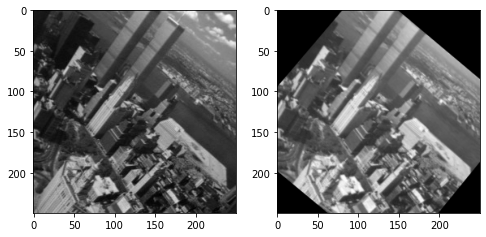

In [26]:
newyork_a_wrapped = cv2.warpPerspective(newyork_a, ny_H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(newyork_a_wrapped, cmap="gray")

In [27]:
graf_a = readGrayF64("./assigments/assigment4/data/graf/graf_a.jpg")
graf_b = readGrayF64("./assigments/assigment4/data/graf/graf_b.jpg")
graf_a.shape, graf_b.shape

((640, 800), (640, 800))

In [28]:
g_points = np.loadtxt("./assigments/assigment4/data/graf/graf.txt")
g_pointsA = list(zip(g_points[:, 1], g_points[:, 0]))
g_pointsB = list(zip(g_points[:, 3], g_points[:, 2]))

In [29]:
g_H = estimate_homography(g_pointsA, g_pointsB)
g_H

array([[ 1.27437554e+00,  3.43710625e-02,  6.81319745e+01],
       [ 2.23945482e-01,  1.21445700e+00, -7.64078762e+01],
       [ 5.99335420e-04,  4.25744503e-05,  1.00000000e+00]])

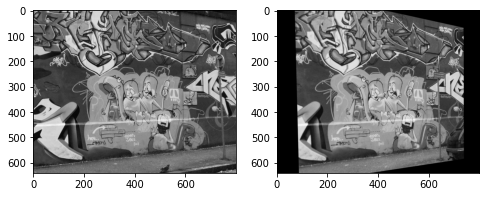

In [30]:
graf_A_wrapped = cv2.warpPerspective(graf_a, g_H, (graf_a.shape[1], graf_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(graf_b, cmap="gray")
axes[1].imshow(graf_A_wrapped, cmap="gray")

#### B

In [31]:
ny_pointsA, ny_pointsB = find_matches(newyork_a, newyork_b, o=4, t=10**-8, nb=10)
len(ny_pointsA), len(ny_pointsB)

(46, 46)

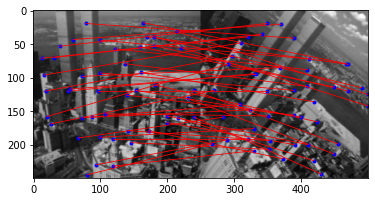

In [32]:
display_matches(newyork_a, ny_pointsA, newyork_b, ny_pointsB)
# we can clearly see that some points are very good matches, but some are terrible (for example short line at the top middle of the image)

In [33]:
def euclidian(x1, y1, x2, y2):
    return np.sqrt((x1 - x2)**2 + (y1 - y2)**2)

def inliers(pointsA, pointsB, H, t):
    points_idx = []
    perror = 0
    for i in range(len(pointsA)):
        v = np.matmul(H, [pointsA[i][1], pointsA[i][0], 1]) 
        v = v / v[-1]

        err = euclidian(v[0], v[1], pointsB[i][1], pointsB[i][0])
        perror += err
        if err < t:
            points_idx.append(i)
    return points_idx, perror / len(pointsA)

def ransac(pointsA, pointsB, k=4, t=0.001):
    options = range(len(pointsA))
    match_sets = combinations(options, r=4)

    k_match_sets = sample(list(match_sets), k=k)
    best_inliers = []
    best_H = None
    best_perror = None
    for matches in k_match_sets:
        H = estimate_homography(np.take(pointsA, matches, axis=0), np.take(pointsB, matches, axis=0))

        inliers_idx, _ = inliers(pointsA, pointsB, H, t)
        if len(inliers_idx) > len(pointsA) * 0.5:
            H = estimate_homography(np.take(pointsA, inliers_idx, axis=0), np.take(pointsB, inliers_idx, axis=0))
            _, perror = inliers(pointsA, pointsB, H, t)
            if best_perror is None or perror < best_perror:
                best_perror = perror
                best_H = H
                best_inliers = inliers_idx
    return best_H, best_inliers, best_perror


In [34]:
seed(10000) # seed 200 with k = 10 works well
H, inliers_idx, perror = ransac(ny_pointsA, ny_pointsB, k=100, t=20)
perror, len(inliers_idx)

(9.979907610212132, 37)

In [35]:
H

array([[ 7.93668710e-01, -5.99145650e-01,  1.13457983e+02],
       [ 6.96259003e-01,  9.39851091e-01, -4.88945317e+01],
       [ 1.56993922e-04,  6.03832999e-04,  1.00000000e+00]])

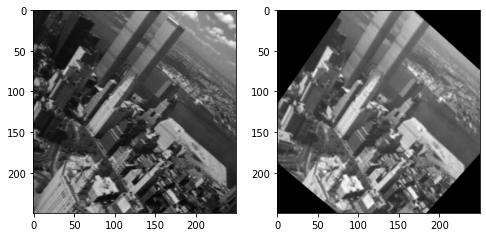

In [36]:
ny_wrapped = cv2.warpPerspective(newyork_a, H, (newyork_a.shape[1], newyork_a.shape[0]))

fig, axes = plt.subplots(1, 2, figsize=(8, 5))

axes[0].imshow(newyork_b, cmap="gray")
axes[1].imshow(ny_wrapped, cmap="gray")

question

### SIFT

In [3]:
from sift import Sift

In [4]:
eiffel_tower = readGrayF64("./assigments/assigment4/data/eiffel_tower.jpg")
eiffel_tower = cv2.resize(eiffel_tower, (0, 0), fx=0.5, fy=0.5)
eiffel_tower.shape

(800, 600)

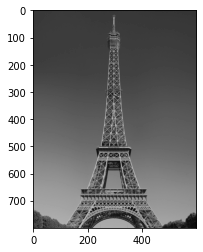

In [5]:
plt.imshow(eiffel_tower, cmap="gray")

In [99]:
levels = 10
sigma = 1.6
sift = Sift(octaves=1, levels=levels, sigma0=sigma, sigmaS=1.2)

In [8]:
pyramid = sift._dog_pyramid(eiffel_tower)
pyramid.shape

(10, 800, 600)

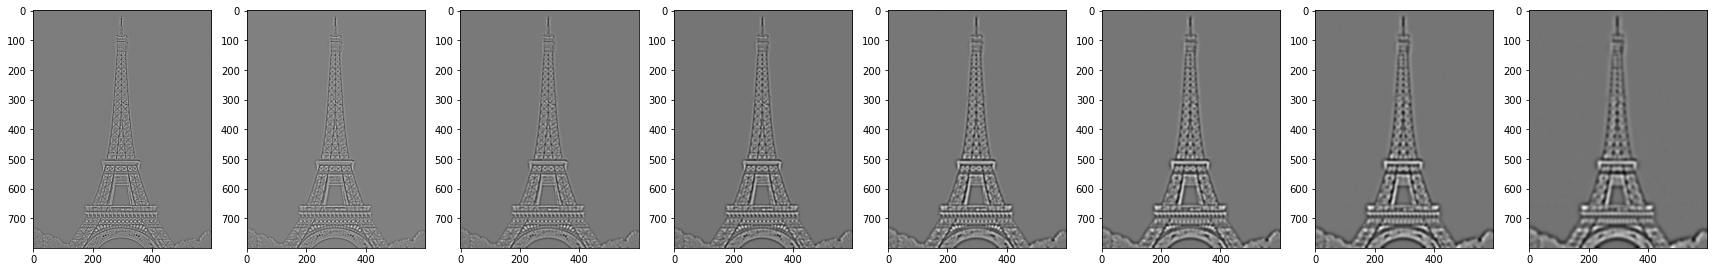

In [9]:
plots = 8
fig, axes = plt.subplots(1, plots, figsize=(30, 10))

for i in range(plots):
    axes[i].imshow(pyramid[i], cmap="gray")

In [10]:
pyramid_maxima = sift._maxima_in_scale_space(pyramid)

In [11]:
pyramid_mx_th = sift._threshold(pyramid_maxima, pyramid_maxima.max() * 0.3)
keypoints = np.argwhere(pyramid_mx_th > 0)
pyramid_maxima.max() * 0.3, len(keypoints)

(0.019837657602851933, 236)

In [101]:
keypoints[:, 0]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 8], dtype=int32)

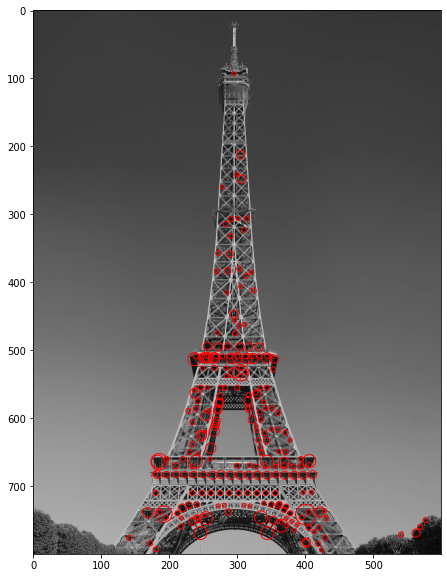

In [104]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(eiffel_tower, cmap="gray")
plt.scatter(keypoints[:, 2], keypoints[:, 1], s=10 * sigma ** keypoints[:, 0], fc='none', ec='r')

In [128]:
top_y = 700
bottom_y = 800
left_x = 300
right_x = 400

eiffel_tower_cutout = eiffel_tower[top_y:bottom_y, left_x:right_x]
eiffel_tower_cutout.shape

(100, 100)

In [129]:
cutout_keypoints = sift._detect_keypoints(eiffel_tower_cutout, 0.02)
len(cutout_keypoints)

25

In [130]:
cutout_keypoints[:, 0] # cutout_keypoints sigma levels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 4,
       6, 6, 6], dtype=int32)

In [131]:
# original keypoints in cutout
original_keypoint_indicies = np.argwhere((keypoints[:, 1] >= top_y) & (keypoints[:, 1] < bottom_y) & (keypoints[:, 2] >= left_x) & (keypoints[:, 2] < right_x))
original_keypoint_indicies = original_keypoint_indicies.flatten()
original_keypoints = keypoints[original_keypoint_indicies]
len(original_keypoints)

26

In [132]:
original_keypoints[:, 0] # original_keypoints sigma levels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       4, 6, 6, 6], dtype=int32)

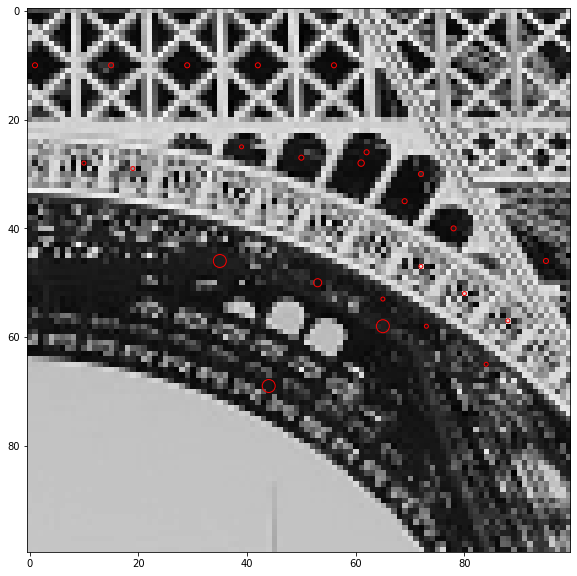

In [134]:
# blob sizes in smaller cutout image
fig = plt.figure(figsize=(10, 10))
plt.imshow(eiffel_tower_cutout, cmap="gray")
plt.scatter(cutout_keypoints[:, 2], cutout_keypoints[:, 1], s=10 * sigma ** cutout_keypoints[:, 0], fc='none', ec='r')

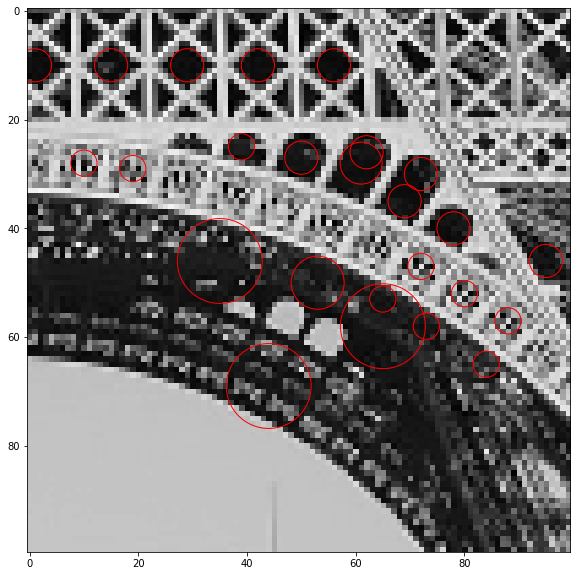

In [135]:
# with scale factor we get correct estimation of blob size in the original image
scale_factor = sigma ** 8 # since we effectively scaled the image by 1/8 this is equal to blurring the image 8 times

fig = plt.figure(figsize=(10, 10))
plt.imshow(eiffel_tower_cutout, cmap="gray")
plt.scatter(cutout_keypoints[:, 2], cutout_keypoints[:, 1], s=scale_factor * 10 * sigma ** cutout_keypoints[:, 0], fc='none', ec='r')